To generate this dataset, I first scraped the most recent posts in 15 of the most popular hashtags:

- fun
- love 
- dog
- instagood
- photooftheday
- food
- instafood
- tbt
- love
- style
- summer 
- winter
- nature
- art
- inspiration 

This resulted in around 60k posts, where I then got rid of all posts with 0 likes and ones that used non-ASCII characters in the caption (so eliminating most non-English languages). This resulted in around 30k posts. 

However, after realizing that these recent posts wouldn't have their maximum number of likes and thus, making my measure of "how good a caption is" inaccurate, I then took the users of these 30k posts and then scraped their 10 most recent posts (and then subtracted the most recent to eliminate the same recency problem). 

For each of these posts, I obtained the caption, picture, number of comments, number of likes, poster's username, number of followers, total number of posts and if the poster were sponsored or not.

In [330]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 50)
import pickle
from post import Post, User
#User: name, posts, num_followers, sponsored, num_posts
#Post: caption, picture, num_comments, num_likes

In [197]:
with open("user_posts.pickle", 'rb') as f:
    dataset = pickle.load(f)

In [198]:
#Defining a class here for each row of the dataframe
class Entry:
    
    def __init__(self, caption, picture, num_comments, num_likes, user_name, num_followers, sponsored, num_posts):
        self.caption = caption
        self.picture = picture
        self.num_comments = comments
        self.num_likes = likes
        self.user_name = user_name
        self.num_followers = num_followers
        self.sponsored = sponsored
        self.num_posts = num_posts

In [199]:
df_dict = {}
df_dict["caption"] = []
df_dict["picture"] = []
df_dict["num_comments"] = []
df_dict["num_likes"] = []
df_dict["username"] = []
df_dict["num_followers"] = []
df_dict["sponsored"] = []
df_dict["num_posts"] = []

for user in dataset:
    for post in user.posts:
        df_dict["caption"].append(post.caption)
        df_dict["picture"].append(post.picture)
        df_dict["num_comments"].append(post.num_comments)
        df_dict["num_likes"].append(post.num_likes)
        df_dict["username"].append(user.name)
        df_dict["num_followers"].append(user.num_followers)
        df_dict["sponsored"].append(user.sponsored)
        df_dict["num_posts"].append(user.num_posts)
        
columns = ["caption", "picture", "num_comments", "num_likes", "username", "num_followers", "sponsored", "num_posts"]

In [200]:
df = pd.DataFrame(df_dict, columns=columns)

Let's do some quick cleaning and data extraction before we look at some overall stats of the dataset. We'll start with getting rid of all captions with language with non-Latin characters, for which we'll need a function to check if a caption is English or an emoji. 

In [201]:
pip install emoji --upgrade

Requirement already up-to-date: emoji in /anaconda3/lib/python3.7/site-packages (0.5.3)
Note: you may need to restart the kernel to use updated packages.


In [202]:
from emoji import UNICODE_EMOJI

def isEnglishOrEmoji(s):
    try:
        for letter in s:
            if letter in UNICODE_EMOJI:
                s = s.replace(letter, "")
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [203]:
#some tests to see if it's working properly
print(isEnglishOrEmoji("👹"))
print(isEnglishOrEmoji("👹asdasdnabsjdn"))
print(isEnglishOrEmoji("🔆 چنانم در دلی حاضر / که جان در جسم و خون در "))
print(isEnglishOrEmoji("👹\n"))

True
True
False
True


I can try a bit harder to get rid of non-English words in the captions (since languages like Spanish use the Latin alphabet as well) but in the grand scheme of things, since we'll be using BERT embeddings, it won't matter since it won't be in the English vocabulary (I'll elaborate on this further).

In [204]:
df["english"] = df['caption'].map(isEnglishOrEmoji)
df = df[df.english == True]

In [205]:
print(len(df))

131257


Now we'll remove links and tags in the caption before separating the hashtags from the caption and moving those into two new columns. We'll also make a new column of the number of hashtags and number of emojis.

In [206]:
import re

def separateHashtags(s):
    hashtags_list = []
    s = re.split(' |\n|[\r\n]+',s)
    for word in s:
        if '#' in word:
            hashtags_list.append(word)
    return hashtags_list

def removeHashtags(s):
    caption = []
    s = re.split(' |\n|[\r\n]+',s)
    for word in s:
        if '#' not in word:
            caption.append(word)
    return " ".join(caption)

def removeLinksAndTags(s):
    caption = []
    s = re.split(' |\n|[\r\n]+',s)
    for word in s:
        if 'https:' not in word and '@' not in word and '.com' not in word:
            caption.append(word)
    return " ".join(caption)

In [207]:
df['caption'] = df['caption'].map(removeLinksAndTags)
df['hashtags'] = df['caption'].map(separateHashtags)
df['caption_no_hashtags'] = df['caption'].map(removeHashtags)
df['num_hashtags'] = df['hashtags'].map(len)

In [208]:
def isEmoji(s):
    emojis = []
    for letter in s:
        if letter in UNICODE_EMOJI:
            emojis.append(letter)
    return emojis

In [209]:
df['emojis']=df['caption'].map(isEmoji)
df['num_emojis']=df['emojis'].map(len)

I'm pretty happy with how this dataset is cleaned and what columns we have, so let's get some initial stats.

Here are some quick stats to look at the distribution of likes and comments (especially since these will be used as a training measure/a measure of how "good" a caption is)

This also means we have around 131k posts to work with.

In [210]:
print(f"Likes Stats: \n\n{df['num_likes'].describe()}\n\n")
print(f"Comments Stats: \n\n{df['num_comments'].describe()}\n\n")
print(f"Followers Stats: \n\n{df['num_followers'].describe()}\n\n")

Likes Stats: 

count    131257.000000
mean     114.346412   
std      1172.074837  
min      0.000000     
25%      12.000000    
50%      26.000000    
75%      61.000000    
max      201612.000000
Name: num_likes, dtype: float64


Comments Stats: 

count    131257.000000
mean     3.478694     
std      25.057022    
min      0.000000     
25%      0.000000     
50%      1.000000     
75%      2.000000     
max      5660.000000  
Name: num_comments, dtype: float64


Followers Stats: 

count    1.312570e+05
mean     3.891421e+03
std      3.851185e+04
min      0.000000e+00
25%      1.570000e+02
50%      4.790000e+02
75%      1.369000e+03
max      4.690537e+06
Name: num_followers, dtype: float64




(0, 1000)

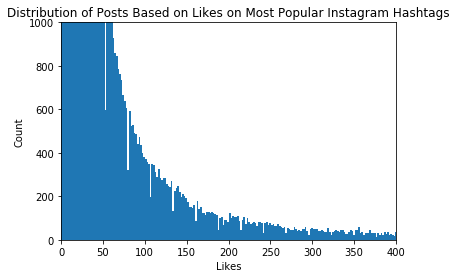

In [39]:
plt.hist(df["num_likes"], bins='auto')
plt.title("Distribution of Posts Based on Likes on Most Popular Instagram Hashtags")
plt.xlabel("Likes")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=400)
plt.ylim(ymin=0, ymax=1000)

(0, 1000)

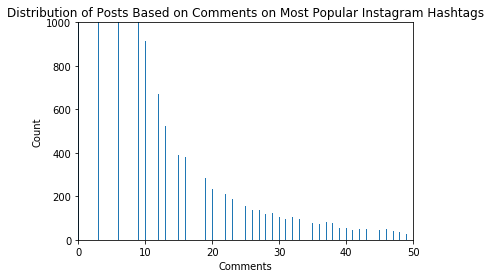

In [40]:
plt.hist(df["num_comments"], bins='auto')
plt.title("Distribution of Posts Based on Comments on Most Popular Instagram Hashtags")
plt.xlabel("Comments")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=50)
plt.ylim(ymin=0, ymax=1000)

Based on the stats above, I'm concerned of how many posts have 0 comments and are from posters with 0 followers

In [211]:
df[df.num_comments==0].count()

caption                59296
picture                59296
num_comments           59296
num_likes              59296
username               59296
num_followers          59296
sponsored              59296
num_posts              59296
english                59296
hashtags               59296
caption_no_hashtags    59296
num_hashtags           59296
emojis                 59296
num_emojis             59296
dtype: int64

In [212]:
df[df.num_followers==0].count()

caption                119
picture                119
num_comments           119
num_likes              119
username               119
num_followers          119
sponsored              119
num_posts              119
english                119
hashtags               119
caption_no_hashtags    119
num_hashtags           119
emojis                 119
num_emojis             119
dtype: int64

That's a bit problematic, especially when we're considering how to combine the likes and comments for a "caption rating." Let's look at some of the top captions based on the number of likes and the number of comments.

In [213]:
df.sort_values(by=['num_likes'], ascending=False)[:10]

caption  \
65553   How am I looking ? 😉 Kya aap sab tab bhi mujhse itna pyar karenge?  #pvp #buddha #greyhair #stylish #potd #amusing #raghbir #love #life #bepanahpyaarr #old #oldagechallenge #faceapp                                                      
65555   No one saves us but ourselves. No one can and no one may. We ourselves must walk the path. : - Buddha . .  #pvp #raghbir #love #potd #ootd #lord #buddha #bepanahpyaarr #life #walk #fashion #in #black                                    
65552   Raghbir Without Beard !!! Going thru my phone gallery n got this !  #raghbir #bepanahpyaarr #love #life #potd #beard #nobeard #pearlvpuri #pvp #pink #red #look                                                                            
65550   No if no but , Sirf JATT !! . . #pvp #pearlvpuri #jatt #raghbir #Bekhayali #bepanahpyaarr #love #life #beard #mustache #muchhi #aviators #punjabi #swag                                                                                    
123517  Hahaha, every cat needs one of these.  #daily #dailykittymail #cat #cats #kitty #kitties #kitten #kittens #cute #wow #wee #adorable #incredible #instagood #instacat #instacats #iloveyou #ilovecats #meow #goodmorning #funny #backyard   
123514  Playing with fire!  #daily #dailykittymail #cat #cats #kitty #kitties #kitten #kittens #cute #wow #wee #adorable #incredible #instagood #instacat #instacats #iloveyou #ilovecats #meow #goodmorning #funny #pool                          
137129  I literally could never do these curls in high school 😂                                                                                                                                                                                    
46051   My body needs exercise, My soul needs  Chhole bhatoore 🙈🙈 #happysunday 🎼🎼🎼🎼🎼 📸 :-                                                                                                                                                          
46046   Be too Much of a Lady to put up with anything less then a Gentleman 💋  My fav skirt #dehradun days ... #backtoschool look #chic                                                                                                            
59262   Caption this 👇🏻😄                                                                                                                                                                                                                           

                                                                                                                                                                                                             picture  \
65553   https://scontent-mia3-1.cdninstagram.com/vp/6f405c9ed7488753fd7157dabdbdeca2/5DED7733/t51.2885-15/e35/p1080x1080/66114975_613305872493744_5830119668265920184_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com    
65555   https://scontent-mia3-1.cdninstagram.com/vp/5acf4bc2b7050eccfef28014cc725a4a/5DC7E28D/t51.2885-15/e35/p1080x1080/62800498_392867088246379_4020776511496837307_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com    
65552   https://scontent-mia3-1.cdninstagram.com/vp/aba7139826c6133447d9a0b2e5d01031/5DE442EB/t51.2885-15/e35/p1080x1080/65845575_613943499129283_3414820006313737003_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com    
65550   https://scontent-mia3-1.cdninstagram.com/vp/2430f66b40050df50b3af756a6fb0370/5DCADB4D/t51.2885-15/e35/p1080x1080/67714357_471788893651251_5443926664742998527_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com    
123517  https://scontent-mia3-1.cdninstagram.com/vp/cbe5f181c940c4c6311de18afbd280bd/5DEDF2DB/t51.2885-15/e35/57121119_634385907054793_2405488519842696483_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com               
123514  https://scontent-mia3-1.cdninstagram.com/vp/3ae749e98599033c9c1091c722a39be9/5DE393D1/t51.2885-15/e35/66440840_2299282470314430_4203300391568209132_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com              
137129  https://scontent-mia3-1.cdni

In [214]:
df.sort_values(by=['num_comments'], ascending=False)[:10]

caption  \
65553   How am I looking ? 😉 Kya aap sab tab bhi mujhse itna pyar karenge?  #pvp #buddha #greyhair #stylish #potd #amusing #raghbir #love #life #bepanahpyaarr #old #oldagechallenge #faceapp                                                                                                                                                                                                          
42971   Tag Someone 😍😊 . . . Follow .  for more friendship posts .. . . . #terejaisayaarkahan #terayaarhoonmain #terimeriyaari #yaarana #dosti #amitabhbachchan #dharmendra #shahrukhkhan #aamirkhan #salmankhan #pakkiyaari #bestfriendsforever #bestiesforlife #bestiegoals #besties👭 #besties💕 #love  #love #bestfriendgoals #bestfriendsforever#followersfreelike #followforfollowback #jabalpur   
65555   No one saves us but ourselves. No one can and no one may. We ourselves must walk the path. : - Buddha . .  #pvp #raghbir #love #potd #ootd #lord #buddha #bepanahpyaarr #life #walk #fashion #in #black                                                                                                                                                                                        
65552   Raghbir Without Beard !!! Going thru my phone gallery n got this !  #raghbir #bepanahpyaarr #love #life #potd #beard #nobeard #pearlvpuri #pvp #pink #red #look                                                                                                                                                                                                                                
65550   No if no but , Sirf JATT !! . . #pvp #pearlvpuri #jatt #raghbir #Bekhayali #bepanahpyaarr #love #life #beard #mustache #muchhi #aviators #punjabi #swag                                                                                                                                                                                                                                        
42967   Tag Someone 😍😊 . . . Follow .  for more friendship posts .. . . . #terejaisayaarkahan #terayaarhoonmain #terimeriyaari #yaarana #dosti #amitabhbachchan #dharmendra #shahrukhkhan #aamirkhan #salmankhan #pakkiyaari #bestfriendsforever #bestiesforlife #bestiegoals #besties👭 #besties💕 #love  #love #bestfriendgoals #bestfriendsforever#followersfreelike #followforfollowback #jabalpur   
74711   When you alive💕  #polikoolle                                                                                                                                                                                                                                                                                                                                                                   
123517  Hahaha, every cat needs one of these.  #daily #dailykittymail #cat #cats #kitty #kitties #kitten #kittens #cute #wow #wee #adorable #incredible #instagood #instacat #instacats #iloveyou #ilovecats #meow #goodmorning #funny #backyard                                                                                                                                                       
103087  Comment your favourite one! 😎❤ #SachinTendulkar #MsDhoni #ViratKohli                                                                                                                                                                                                                                                                                                                           
68558   Tag a Tik-Toker😂 . Follow the page. Like and share the post. Check the stories. . . #love #couple #cute #girl #boy #beautiful #instagood #instalove #loveher #lovehim #pretty #adorable #forever #girlfriend #boyfriend #gf #bf #bff #together #photooftheday #happy #fun #smile #xoxo #l4l #meme #laughter #engineer #students #engineering                                                   

                                                                    

These aren't bad, but we can try to improve them by normalizing the likes and comments by the number of followers the poster has. This'll make it so that the best posts aren't necessarily always from those with the most followers/exposure.

In [215]:
df["num_followers"] = df["num_followers"].replace(0, df["num_followers"].mean())    

In [216]:
df["normalized_likes"] = df['num_likes'] / df['num_followers']
df["normalized_comments"] = df['num_comments'] / df['num_followers']

In [217]:
df.sort_values(by=['normalized_likes'], ascending=False)[:10]

caption  \
156279  Haha Mr. Maheswaran! This is so cute! - Credit : - - - - - - - - Tags 📌 : #stevenuniverse #rebeccasugar #cartoonnetwork #steven #pearl #whitediamond #diamondauthority #garnet #amythest #connie #stevonnie #fusions #opal #beachcity #homeworld #rosequarts #smokeyquarts #lars #sadie #art                                                                                                                                 
127236  Brrrrr 'BEBESITA 😍  #anuel  #karolg #micama #emprendedores  #colombia  #photography                                                                                                                                                                                                                                                                                                                                          
88207   #nature #flowers #sky #beautiful #hunter #rainbow #farm #likeforfollow #likeforlikes #love #moments #best                                                                                                                                                                                                                                                                                                                    
113890  Beautiful shot of the resort at Maldives by  #travelgram #maldives #vacations #vacation #photography #beautiful #dronephotography #dronestagram #drone #mavic2pro #hasselblad #uniladadventures #unilandadventure                                                                                                                                                                                                            
113892  Beautiful By  #nature #forest #photography #dslr_photography #dslr #uniladadventure #drone #dji #mavicair #mavic #mavicpro #mavic2pro #worldbestshot                                                                                                                                                                                                                                                                         
148239  Has you can see 4 in 1 bow headband,green color🌱🍃🍀💚 2015... . . . #knitting#green#winter#tumblr#cozy#comfortable#fashionista#fashionstyle#fashion#fashionblogger#fashionblog#fashionlover#fashiondaily#fashionaddict#styletips#modafeminina#outfitinspiration#outfitpost#style#styleblogger#styleoftheday#styleinspiration#streetstyleluxe#instafashion#outfit#fashioninspo#stylish#potd#asafliberfrund#fashionphotography   
47115   Amazing drawing by !! #flowerdrawing #drawing #drawthisinyourstyle #draw #drawings #pretty #cool #likethis #followme #followus #follow #like #likeaboss #instalike #instagramer #instagram #talent #talented #viral #makethisviral #famous #fame #amazing                                                                                                                                                                    
88205   #nature #flowers #sky #hunter #moments #best #beautiful #likeforfollow #likeforlikes #amazing #love #cute #pretty                                                                                                                                                                                                                                                                                                            
155364  Beats of the Earth #sketchbook #sketch #ink #draws #drawing #drawings #sketching #rapidograph #art #arts #artist #tree #trees                                                                                                                                                                                                                                                                                                
113891  I need to go on a vacation!  What a beautiful shot by  #photooftheday #love #nature #travel #vacation #travelgram #dslr_photography #dslr #drone #dronephotography #dronestagram #dji #

In [218]:
df.sort_values(by=['normalized_comments'], ascending=False)[:10]

caption  \
113889  Follow us for more amazing drone shots  By  #nature #naturelovers #unilandadventure #drone #dronephotography #dronestagram #travelgram #photooftheday #dslr_photography #mavic #mavicair #mavicpro                                                                                                                                                                                                                                                                                         
106745  We stay positive here!💞 #pretty #positivequotes #pastel #love #hairstyles #glitter #fun #sparkle #adventure #adorable #me #cute #egirl #egirls #bff #bffgoals #bffs #bffsforever                                                                                                                                                                                                                                                                                                           
158975  Follow me #instadaily #india #instalike #viral #trending #picoftheday #lifestyle #movie #film #life #london #instafashion #luxury #newyork #mumbai #star #nollywood #makeup #repost #photoshoot #dj #fashionista #blogger #happy #hot #usa #lagos #celebs #media #handsome                                                                                                                                                                                                                 
113890  Beautiful shot of the resort at Maldives by  #travelgram #maldives #vacations #vacation #photography #beautiful #dronephotography #dronestagram #drone #mavic2pro #hasselblad #uniladadventures #unilandadventure                                                                                                                                                                                                                                                                          
1930    🌘When will Sailor Moon and Steven Universe crossover?🌒                                                                                                                                                                                                                                                                                                                                                                                                                                     
117806  sunkissed💋💋.                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
8178    Grey Flynn cushions  #kmart #kmarthomedecor #kmarthome #kmarthomewares #kmartdecor #kmartaustralia #cushion #homedecor #decor #home #comfort #style #instastyle #retailtherapy #shopping #bargan #love #decorate #grey #soft  #pillow #buy  #kmartmum #k #woven #ontrend #classic #kmartstyling #kmartaddict #kmartliving                                                                                                                                                                  
105796  Concealed book in us. --- #poetriesgram #wordporn #igpoets #bymepoetryasia #writerscommunity #poemsofinstagram #writersofinstagram #writerscommunity #writer #writersnetwork #lovepoems #poemsporn #poetsofinstagram #writingcommunity #poetry #quotesoftheday #poetryporn #spilledink #igpoet #instaquotes #poetryisnotdead #poetsandwritersfeature #wordporn #dailypoets #poems #love                                                                                                    
79879   Guess the correct answer and win Rs 200 voucher at Jain Subkuchh food Plaza. Contest valid till 26th July 201

In [219]:
df["caption_rating"] = (100*df["normalized_likes"] + df["normalized_comments"] + df["num_likes"])/2


In [220]:
df.sort_values(by=['caption_rating'], ascending=False)[:20]["caption_no_hashtags"]

65553     How am I looking ? 😉 Kya aap sab tab bhi mujhse itna pyar karenge?                                        
65555     No one saves us but ourselves. No one can and no one may. We ourselves must walk the path. : - Buddha . . 
65552     Raghbir Without Beard !!! Going thru my phone gallery n got this !                                        
65550     No if no but , Sirf JATT !! . .                                                                           
123517    Hahaha, every cat needs one of these.                                                                     
123514    Playing with fire!                                                                                        
137129    I literally could never do these curls in high school 😂                                                   
46051     My body needs exercise, My soul needs  Chhole bhatoore 🙈🙈 🎼🎼🎼🎼🎼 📸 :-                                      
46046     Be too Much of a Lady to put up with anything less the

This seems to give us the best captions, but of course, we can first look at other parts of the dataset before coming back to this problem.

## Engagement Rate

An interesting statistic that Instagram "influencers" always focus on is the <b>engagement rate</b>. <br>

[Scrunch](https://www.scrunch.com/blog/what-is-a-good-engagement-rate-on-instagram) describes this as:

<i> To calculate an engagement rate on Instagram, follow the steps below:

1. Look at all of the influencers posts for the last 30 days and add up the total number of likes and comments on each post (e.g. if there are 17 posts in the last 30 days, add up the number of likes and comments on each of the 17 posts). 
2. Divide that number by the number of posts there are in the last 30 days (e.g. divide the total number of likes and comments from above, by the number of posts - 17 in this example). 
3. Now that you have the average engagements per post, divide that by the number of followers the influencer has. 
4. Finally, times the number above by 100, to turn the numbers into a percentage (the percentage will usually be between 0 and 10). This is the engagement rate of the influencer on Instagram.

</i>

This is a statistic that sponsors use to determine whether or not to work with a particular user. We'll use the above to calculate the engagement rate of every post's poster


In [222]:
df['valid_followers'] = df['num_followers'].apply(lambda x: 1 if int(x) != 114 else 0)


In [187]:
engagement_rate = {}
for index, row in df.iterrows():
    if row["username"] in engagement_rate:
        value = (row["num_comments"] + row["num_likes"])/(row["num_followers"])
        engagement_rate[row["username"]].append(value)
    else:
        value = (row["num_comments"] + row["num_likes"])/(row["num_followers"])
        engagement_rate[row["username"]] = []
        engagement_rate[row["username"]].append(value)

In [235]:
df['user_post_engagements'] = df["username"].map(engagement_rate)

engagement_rates = []
for index, row in df.iterrows():
    engagement_rates.append(sum(row["user_post_engagements"])/len(row["user_post_engagements"]))    

In [236]:
import numpy as np
df["engagement_rate"] = np.asarray(engagement_rates)

In [237]:
print(f"Engagement Rate Stats: \n\n{df['engagement_rate'].describe()}\n\n")
      

Engagement Rate Stats: 

count    131257.000000
mean     0.140319     
std      0.272433     
min      0.000000     
25%      0.029034     
50%      0.077991     
75%      0.168936     
max      24.333333    
Name: engagement_rate, dtype: float64




In [267]:
df.sort_values(by=['engagement_rate', 'num_followers'], ascending=False)[:50]

caption  \
127236  Brrrrr 'BEBESITA 😍  #anuel  #karolg #micama #emprendedores  #colombia  #photography                                                                                                                                                                                                                                                                                                                                                                                 
148239  Has you can see 4 in 1 bow headband,green color🌱🍃🍀💚 2015... . . . #knitting#green#winter#tumblr#cozy#comfortable#fashionista#fashionstyle#fashion#fashionblogger#fashionblog#fashionlover#fashiondaily#fashionaddict#styletips#modafeminina#outfitinspiration#outfitpost#style#styleblogger#styleoftheday#styleinspiration#streetstyleluxe#instafashion#outfit#fashioninspo#stylish#potd#asafliberfrund#fashionphotography                                          
113888  Follow us for more amazing drone shots  By  #nature #naturelovers #unilandadventure #drone #dronephotography #dronestagram #travelgram #photooftheday #dslr_photography #mavic #mavicair #mavicpro                                                                                                                                                                                                                                                                  
113889  Follow us for more amazing drone shots  By  #nature #naturelovers #unilandadventure #drone #dronephotography #dronestagram #travelgram #photooftheday #dslr_photography #mavic #mavicair #mavicpro                                                                                                                                                                                                                                                                  
113890  Beautiful shot of the resort at Maldives by  #travelgram #maldives #vacations #vacation #photography #beautiful #dronephotography #dronestagram #drone #mavic2pro #hasselblad #uniladadventures #unilandadventure                                                                                                                                                                                                                                                   
113891  I need to go on a vacation!  What a beautiful shot by  #photooftheday #love #nature #travel #vacation #travelgram #dslr_photography #dslr #drone #dronephotography #dronestagram #dji #djimavic #djimavicpro #mavic2prohasselblad                                                                                                                                                                                                                                   
113892  Beautiful By  #nature #forest #photography #dslr_photography #dslr #uniladadventure #drone #dji #mavicair #mavic #mavicpro #mavic2pro #worldbestshot                                                                                                                                                                                                                                                                                                                
113893  What a great shot by  #nyc #bestnatureshot #dji #djimavic #drone #dslr #photography #newyork #nightshot #uniladadventure #worldbestshot #dslr_photography #photo                                                                                                                                                                                                                                                                                                    
113894  By  #drone #dslr #dji #djimavic #mavic #mavicpro #mavicair #uniladadventure #adventure #pool #vacation #summer                                                                                                                                                                                       

Scrunch then goes on to describe how these engagement rates are interpreted:

- Less than 1% = low engagement rate 
- Between 1% and 3.5% = average/good engagement rate 
- Between 3.5% and 6% = high engagement rate 
- Above 6% = very high engagement rate 

where low engagement rate is generally associated with unengaged followers, which can mean that the user has "fake" or "ghost" followers

However, it's important to note that with the majority of the high engagement posters, they have very low number of followers, so this statistic isn't necessarily indicative of a user having ghost followers.

### Low Engagement


In [268]:
ghost_df = df

In [269]:
ghost_df[ghost_df['engagement_rate'] < 1.0].count()

caption                  130095
picture                  130095
num_comments             130095
num_likes                130095
username                 130095
num_followers            130095
sponsored                130095
num_posts                130095
english                  130095
hashtags                 130095
caption_no_hashtags      130095
num_hashtags             130095
emojis                   130095
num_emojis               130095
normalized_likes         130095
normalized_comments      130095
caption_rating           130095
valid_followers          130095
user_post_engagements    130095
engagement_rate          130095
dtype: int64

In [270]:
ghost_df[ghost_df['engagement_rate'] < 1.0]

caption  \
0       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel #deus                                                                                                                                                                                  
1       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
2       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
3       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
4       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
5       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
6       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
7       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #diadoamigo                                                                                                                                                                                        
8       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
9       #lo

And as you can see, these users look very suspicious, with most of them having a considerable number of followers but significantly less likes on their posts.

### Influencers and High Engagement

Let's look at who could potentially be influencers though. Users generally have to have around 15k followers before they get their first offer from a sponsor, so let's first identify those users before looking at their engagement rate.

In [277]:
influencer_df = df[df['num_followers'] > 15000]

In [278]:
influencer_df = influencer_df.drop_duplicates(subset="username")

In [279]:
influencer_df.count()

caption                  687
picture                  687
num_comments             687
num_likes                687
username                 687
num_followers            687
sponsored                687
num_posts                687
english                  687
hashtags                 687
caption_no_hashtags      687
num_hashtags             687
emojis                   687
num_emojis               687
normalized_likes         687
normalized_comments      687
caption_rating           687
valid_followers          687
user_post_engagements    687
engagement_rate          687
dtype: int64

In [280]:
influencer_df.sort_values(by=['engagement_rate', "num_followers"], ascending=False)

caption  \
123507  Well, we always knew that cats controlled the world.... #daily #dailykittymail #cat #cats #kitty #kitties #kitten #kittens #cute #wow #wee #adorable #incredible #instagood #instacat #instacats #iloveyou #ilovecats #meow #goodmorning #funny #food                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
42964   Tag Someone 😍😍 . . . Follow .  for more friendship posts .. . . . #terejaisayaarkahan #terayaarhoonmain #terimeriyaari #yaarana #dosti #amitabhbachchan #dharmendra #shahrukhkhan #aamirkhan #salmankhan #pakkiyaari #bestfriendsforever #bestiesforlife #bestiegoals #besties👭 #besties💕 #love  #love #bestfriendgoals #bestfriendsforever#followersfreelike #followforfollowback #jabalpur                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
137125  I second the shit out of this 😩😩                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
10515   Pratite                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Unfortunately, even though when scraping for the data, the structure allowed for a "sponsored" area, all of the posts that we scraped had that value set as False, so we can't use it as a verifier for whether or not a user is actually an "influencer." However, we can now use this engagement rate as a solid variable to check whether or not particular features of the caption are useful.

## Popular Hashtags

The users above have a high engagement rate on the post that I've scraped and from a cursory glance, it seems as though they use a large number of hashtags. This makes sense given that you would want to use as many hashtags as possible in order to reach as wide of an audience as possible. 

In [282]:
df['engagement_rate'].corr(df['num_hashtags'])

0.02367011171648171

It doesn't seem like this is the case. Maybe it would be better to look at specifically which hashtags are being used?

In [283]:
hashtag_count = {}
for list_hashtag in df['hashtags']:
    for hashtag in list_hashtag:
        if hashtag in hashtag_count:
            hashtag_count[hashtag] += 1
        else:
            hashtag_count[hashtag] = 1

In [302]:
max(hashtag_count, key=hashtag_count.get) #seeing the most commonly used hashtag

'#love'

In [303]:
hashtag_count_weighted = {}
for list_hashtag, engagement in zip(df['hashtags'], df['engagement_rate']):
    for hashtag in list_hashtag:
        if hashtag in hashtag_count_weighted:
            hashtag_count_weighted[hashtag] += engagement
        else:
            hashtag_count_weighted[hashtag] = engagement

In [304]:
key = max(hashtag_count_weighted, key=hashtag_count_weighted.get)
print((key, hashtag_count_weighted[key]))

counter = 0
for index, row in df.iterrows():
    if key in row['hashtags']:
        counter += 1
print(counter/131257)

('#love', 6960.423257462373)
0.358502784613392


In [287]:
df[df['num_hashtags'] != 0].count() 

caption                  105322
picture                  105322
num_comments             105322
num_likes                105322
username                 105322
num_followers            105322
sponsored                105322
num_posts                105322
english                  105322
hashtags                 105322
caption_no_hashtags      105322
num_hashtags             105322
emojis                   105322
num_emojis               105322
normalized_likes         105322
normalized_comments      105322
caption_rating           105322
valid_followers          105322
user_post_engagements    105322
engagement_rate          105322
dtype: int64

From the above, we can see that about 80% of all of the posts that we obtained use some form of hashtag. In addition, the 5 most impactful hashtags for getting a high engagement rate (associated with high number of followers, likes and comments) are love, instagood, photooftheday, art and photography (with 36%, 18%, 16%, 11% and 11% of the posts using each of those hashtags respectively). 

In [332]:
df["num_hashtags"].describe()

count    131257.000000
mean     15.221413    
std      12.454085    
min      0.000000     
25%      1.000000     
50%      15.000000    
75%      28.000000    
max      230.000000   
Name: num_hashtags, dtype: float64

There are, on average, 15 hashtags per post, which indicates that our caption generator should try and recommend some hashtags for the user to use. It would be easy for it to just split the caption generated into words and then spit that back out as hashtags; however, more robust means can be done.

But with the new influencer information in mind, we can try to make a new caption_rating column.

In [311]:
df["caption_rating"] = (100*df["normalized_likes"] + df["normalized_comments"] + df["num_likes"])*df["engagement_rate"]/2
df.sort_values(by=['caption_rating'], ascending=False)[:50]["caption_no_hashtags"]


11260     It think it's how Fred and George probably peaked him so often that it became a reflex ! . . . . . . . . .                                            
11261     What is your one favourite scene in all of the 8 Harry Potter Movies?  Follow for more⚡❤ . . . . . . . . .                                            
127236    Brrrrr 'BEBESITA 😍                                                                                                                                    
156279    Haha Mr. Maheswaran! This is so cute! - Credit : - - - - - - - - Tags 📌 :                                                                             
123517    Hahaha, every cat needs one of these.                                                                                                                 
123514    Playing with fire!                                                                                                                                    
107457    (in January 2018 )Holida

These results are pretty good for caption ratings! Let's look at this dataset a bit further then with this new measure

## Emojis

We want to see if there's any correlation between the number of emojis and the engagement rate (or any of our other measures). This will help us decide whether or not our caption generator should recommend emojis or not

In [316]:
df[df.num_emojis != 0].count()

caption                  50158
picture                  50158
num_comments             50158
num_likes                50158
username                 50158
num_followers            50158
sponsored                50158
num_posts                50158
english                  50158
hashtags                 50158
caption_no_hashtags      50158
num_hashtags             50158
emojis                   50158
num_emojis               50158
normalized_likes         50158
normalized_comments      50158
caption_rating           50158
valid_followers          50158
user_post_engagements    50158
engagement_rate          50158
dtype: int64

In [322]:
print(df['engagement_rate'].corr(df['num_emojis']))
print(df['caption_rating'].corr(df['num_emojis']))
print(df['num_likes'].corr(df['num_emojis']))
print(df['num_followers'].corr(df['num_emojis']))
print(df['num_comments'].corr(df['num_emojis']))
print(df['num_hashtags'].corr(df['num_emojis']))

-0.011688268697244375
8.91721826481546e-05
0.018715366634096075
0.03541588860069356
0.021910889997067178
0.04797985443113013


In [320]:
df.sort_values(by=['num_emojis'], ascending=False)[:20]

caption  \
75190  😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😙😙😙😙😙😙😙😙😙😙😋😋😋😋😋😋😋😋😋😋😋😚😚😚😚😚😚😚😚😚😚😚😛😛😛😛😛😛😛😛😛😛😛😛😛😛😛😛😉😉😉😉😉😉😉😉❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤💕💕💕💕💕💕💕💕💕💕💕💕💕💖💖💖💖💖💖💖💖💖💞💞💞💞💞💞💞💞💞💞💞💞💘💘💘💘💘💘💘💘💘💘💘💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝💝   ❤ ❤ 💞 💞 💞  #lovequotes#lovelines#lovelydp#followforfollowme#beautiful#romanticdp#dpzzamazing💕💕💕💕💕💖💖💖💖💖💖💖💟💟💟💟💟💞💞💞💞💞💝💝💝💝💞💞💞💝💝💝💝💝💝💝💞💟💟💕💕💖💖💕💖💖💕💖💕💖💖#followforfollow#lovequotespics#lovelines#lover#lovers#beautifuldpz😍😍😍😍😘😘😘😘💘💘💘💘💋💋💋💞💞💞#follow#lovelines                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
75191  😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😚😚😚😚😚😚😚😚😚😚😚😚😚😚😚😚😚😚😚😙😙😙😙😙😙😙😙😙😙😋😋😋😋😋😋😋😋😋😋😋😋😋😋😋😋😋😋❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💘💘💘💘💘💘💘💘💘💘💘💟💟💟💟💟💞💞💞💞💞💞💞💞💞💞💞💞💞💗💗💗💗💗💗💗💗  follow  follow  follow follow follow ❤❤❤ #followforfollow#followforfollowme#dpzzamazing💕💕💕💕💕💖💖💖💖💖💖💖💟💟💟💟💟💞💞💞💞💞💝💝💝💝💞💞💞💝💝💝💝💝💝💝💞💟💟💕💕💖💖💕💖💖💕💖💕💖💖#love#lovequotes#lovelines#lover#follow4like#stylishdpz#follow#lovelines                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
75189  😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😣😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😚😚😚😚😚😚😚😚😚😚😚😘😘😘😘😙😙😙😙😙😘😋😋😋😋😋😋😋😋❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤💖💖💖💖💖💖💖💖💖💖💖💖💖💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💘💘💘💘💘💘💘💘💘💘💘💘💘💝💝💝💝💝💝💝💝💝💝💝💝💝💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💞💓💓💓💓💓💓💓💓💓💓💓💓 💔💔💔💔  #followforfollowme#lovequotes#lovelines#missyouquotes#dpzzamazing#followforfollow#follow4like#lovelive#beautifuldpz#lovelines#dp#missyouquotes#followforfollow#follow4like#missyou#follow#lovelines..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
75194  😉😉😉😉😉😉😉😉😉😉😍😍😍😍😍😙😙😙😙😙😙😙😙😙😙😘😘😘😘😘😘😘😘😘😘😍😍😍😍❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤💞💞💞💞💞💞💞💞💞💞💞💞💞💖💖💖💖💖💖💖💖💖💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💗💞💞💞💞💞💞💞💞💞💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💕💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💓💟💟💟💟💟💟💟💟💟💟 follow follow _lines_543 follow _lines_543  Follow _lines_543 Follow _lines_543 😍😍😍😍😍😍😍😍 😍 😍 😍 😍 😍 😍 😍  #love#lovelines#                                                                                                                                                                                                                                                                                                  

In [321]:
df["num_emojis"].describe()

count    131257.000000
mean     1.071463     
std      3.508444     
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      1.000000     
max      270.000000   
Name: num_emojis, dtype: float64

So it seems like about 60% of the posts we have use emojis. From that and prior knowledge of emojis, it seems like there should be some positive correlation between the addition of emojis and any indicator of post success (like, comment, number of followers, engagement rate, etc). However, the correlation values indicated otherwise and upon seeing the 20 posts with the emojis, it becomes clear why. 

There are plenty of "spam" posts out there that just use an overwhelming amount of emojis. Despite this, a post uses, on average, one emoji. With this in mind, it might make sense for our caption generator to recommend one or two emojis per caption (based on what words in there have a corresponding emoji with it).

## Length of Caption

Another important aspect of captions is the length of it and whether or not that affects the effectiveness of it. Let's once again evaluate this, in a similar fashion to the emojis section above.

In [325]:
df["full_caption_length"] = df["caption"].map(len)
df["no_hashtag_caption_length"] = df["caption_no_hashtags"].map(len)

In [327]:
print("Correlation values using Full Caption Length")
print(df['engagement_rate'].corr(df['full_caption_length']))
print(df['caption_rating'].corr(df['full_caption_length']))
print(df['num_likes'].corr(df['full_caption_length']))
print(df['num_followers'].corr(df['full_caption_length']))
print(df['num_comments'].corr(df['full_caption_length']))

print("Correlation values using No Hashtag Caption Length")
print(df['engagement_rate'].corr(df['no_hashtag_caption_length']))
print(df['caption_rating'].corr(df['no_hashtag_caption_length']))
print(df['num_likes'].corr(df['no_hashtag_caption_length']))
print(df['num_followers'].corr(df['no_hashtag_caption_length']))
print(df['num_comments'].corr(df['no_hashtag_caption_length']))

Correlation values using Full Caption Length
-0.011794419703466846
0.0007416481280715421
0.0008203626965942663
0.006433240391209099
0.006877410611485937
Correlation values using No Hashtag Caption Length
-0.036893106709573
-0.00157151745428335
0.0031105507898542334
0.014290818680763089
0.015604096950405337


In [328]:
df["no_hashtag_caption_length"].describe()

count    131257.000000
mean     54.698774    
std      124.169695   
min      0.000000     
25%      0.000000     
50%      20.000000    
75%      57.000000    
max      2200.000000  
Name: no_hashtag_caption_length, dtype: float64

In [331]:
df

caption  \
0       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel #deus                                                                                                                                                                                  
1       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
2       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
3       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
4       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
5       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
6       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
7       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #diadoamigo                                                                                                                                                                                        
8       #love #instagood #photooftheday #fashion #beautiful #happy #cute #tbt #like4like #followme #picoftheday #follow #me #selfie #summer #instadaily #art #friends #repost #nature #girl #repost #nature #girl #fun #style #smile #food #instalike #family #travel                                                                                                                                                                                    
9       #lo

On average, a caption has 54 characters, which equates to roughly 9 words (since in English, the average number of characters per word is 6). There isn't any correlation between a longer caption and a more successful post but based on prior knowledge, it'd probably be ideal to avoid a long post. 

## Concluding Thoughts

With all of this in mind, it makes most sense that the caption generator should spit out a caption (around 9 words or so) with one or two emojis as well as a list of hashtags to include with them.

Given that in order to generate the caption in the first place, one will need to identify features within the image, these features can be used as hashtags as well (or emojis), making our output job a bit easier. 

However, that's about as much analysis I'd like to do on this dataset before going and trying to implement this model. I'll attach this dataset as a pickle file for anyone interested so that you can take a look yourself!

In [338]:
with open("insta_data.pickle", 'wb') as f:
    pickle.dump(df, f)